In [1]:
library(rstan)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

Loading required package: StanHeaders


rstan version 2.32.7 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




# Exercise 1: Quadratic Bayesian regression using Stan
The following n = 9 data sample

| X  |  Y        |  $\sigma_i$  |
|----|-----------|-----------|
| 2  | 105.5203  | 15.40459  |
| 3  | 227.4457  | 36.05480  |
| 4  | 405.6937  | 51.84040  |
| 5  | 661.2858  | 94.66744  |
| 6  | 886.1422  | 123.79828 |
| 7  | 1189.6514 | 216.99935 |
| 8  | 1631.8262 | 173.83507 |
| 9  | 1951.8381 | 318.46511 |
| 10 | 2528.5246 | 427.27788 |

is believed to follow
 
$ Y = \beta_0 + \beta_1 \cdot X + \beta_2 \cdot X^2 $

Let the prior distributions for $\beta$ parameters be,
- $\beta_0$ normal distribution centered at 5 with a standard deviation of 1.
- $\beta_1$ uniform distribution between -1 and 1.
- $\beta_2$ normal distribution centered at 30 with a standard deviation of 15.

Build a Stan model and run a MCMC to obtain the posterior distribution of the $\beta$ parameters using also the $\sigma_i$ uncertainty for each measurement.

Compute 95% credibility intervals for each $\beta$ parameter.

Draw the fitted quadratic funtion (using the mean values of the β parameters from MCMC) together with data points and their uncertainties.

# Exercise 2

A study on water quality of streams, a high level of bacter X was defined as a level greater than 100 per 100 ml of stream water. n = 115 samples were taken from streams having a high environmental
impact on pandas. Out of these, y = 10 had a high bacter X level.

Letting p be the probability that a sample of water taken from the stream has a high bacter X level,\
(a) Find the frequentist estimator for p.\
(b) Using a Beta(1, 11) prior for p, calculate and posterior distribution $P(p | y)$.\
(c) Find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval.\
(d) Test the hypothesis $H_0: p = 0.1$ versus $H_1: p \neq 0.1$ at 5% level of significance with both the frequentist and bayesian approach.

In [2]:
n <- 115
y <- 10

# a)
p_freq <- y / n
cat("Frequentist estimator p =", p_freq)

Frequentist estimator p = 0.08695652

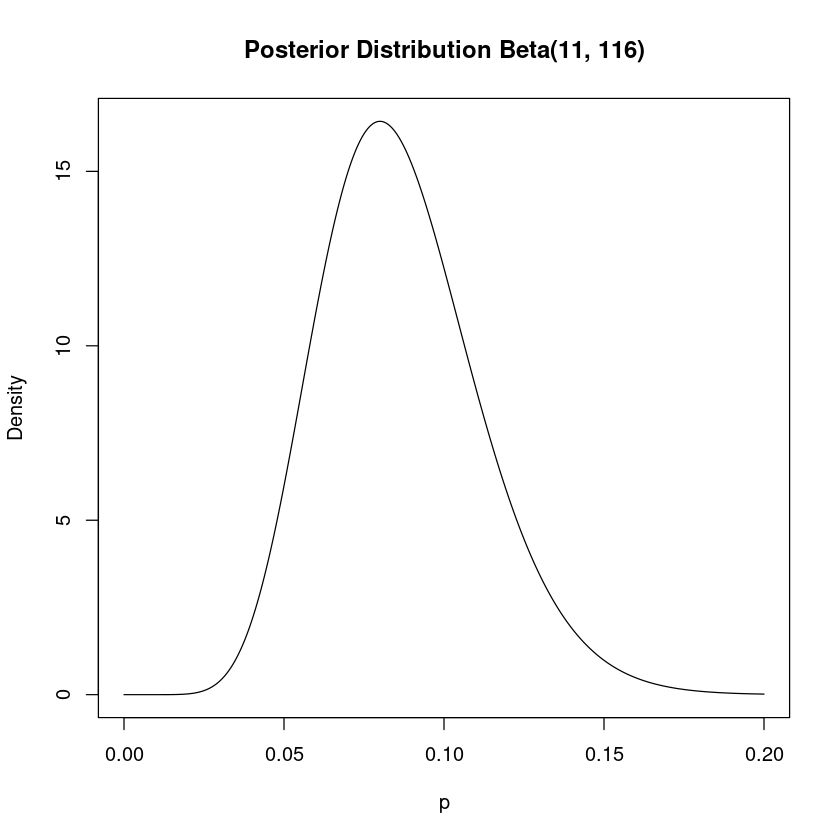

In [3]:
# b)
a_post <- 1 + y
b_post <- 11 + n - y
list_x <- seq(0,0.2,length.out=1000)
plot(list_x, dbeta(list_x,a_post,b_post), 
     type = "l", xlab = "p", ylab = "Density",
     main = "Posterior Distribution Beta(11, 116)"
)

In [4]:
# c)
p_mean <- a_post / (a_post + b_post)
p_var <- (a_post * b_post) / ((a_post + b_post)^2 * (a_post + b_post + 1))
ci <- qbeta(c(0.025, 0.975), a_post, b_post)

cat("Posterior mean:", p_mean)
cat("\nPosterior variance:", p_var)
cat("\n95% credible interval: [", ci[1], ",", ci[2], "]")

Posterior mean: 0.08661417
Posterior variance: 0.0006180637
95% credible interval: [ 0.04438876 , 0.1411131 ]

In [5]:
# d) frequentist
p0 <- 0.1
se <- sqrt((p0*(1-p0))/n) # standard error
z_value <- (p_freq) / se
p_value <- 2 * (1 - pnorm(abs(z_value)))
cat("Frequentist approach:")
cat("\nz-value:", z_value)
cat("\np-value:", p_value)
if (p_value < 0.05) {
    cat("\n=> Reject H_0")
} else {
    cat("\n=> Don't reject H_0")
}

# d) bayesian
cat("\n\nBayesian approach:")
if (0.1 >= ci[1] & 0.1 <= ci[2]) {
    cat("\n=> Don't reject H_0")
} else {
    cat("\n=> Reject H_0")
}

Frequentist approach:
z-value: 3.108349
p-value: 0.001881355
=> Reject H_0

Bayesian approach:
=> Don't reject H_0

A new measurement, performed one month later on n = 165 water samples, gives y = 9 high bacter X level\
(e) Find the frequentist estimator for p.\
(f) Find a bayesian estimator for p, assuming both a Beta(1, 10) prior for p, and assuming the posterior probability of the older measurement as the prior for the new one.\
(g) Find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval.\
(h) Test the hypothesis $H_0: p = 0.1$ versus $H_1: p \neq 0.1$ at 5% level of significance with both the frequentist and bayesian approach.

In [6]:
# e)
new_n <- 165
new_y <- 9
new_p_freq <- new_y / new_n
cat("Frequentist estimator p =", p_freq)

Frequentist estimator p = 0.08695652

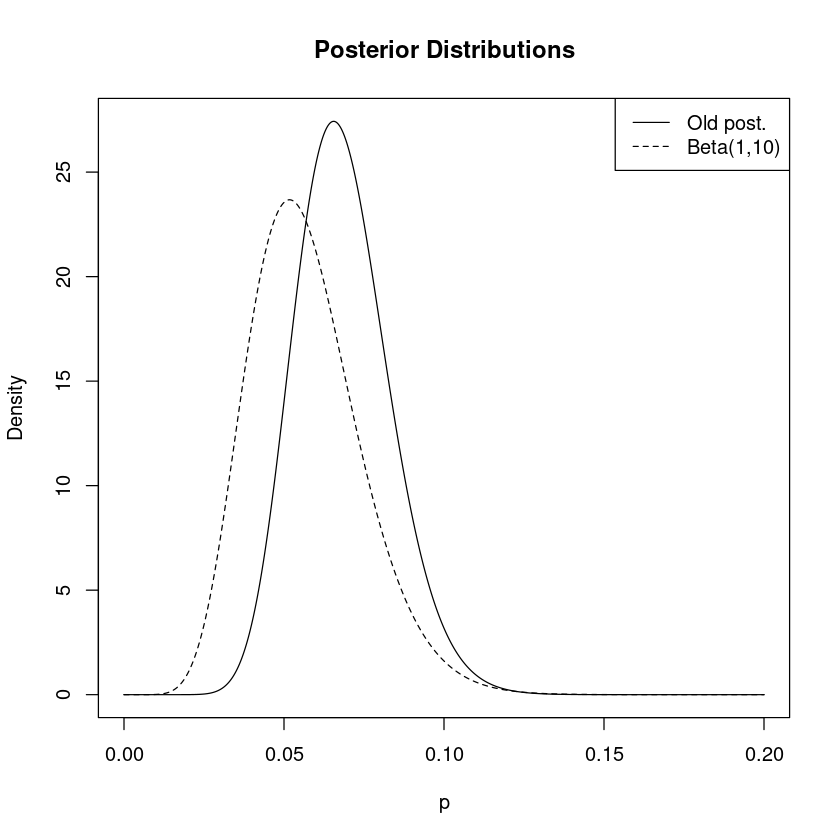

In [7]:
# f) 
a_post_2a <- 1 + new_y
b_post_2a <- 10 + new_n - new_y

a_post_2b <- a_post + new_y
b_post_2b <- b_post + new_n - new_y

list_x <- seq(0,0.2,length.out=1000)
plot(list_x, dbeta(list_x, a_post_2b, b_post_2b),
     type="l", xlab = "p", ylab = "Density", 
     main = "Posterior Distributions"
)
lines(list_x, dbeta(list_x, a_post_2a, b_post_2a),
      lty = 2
)
legend("topright", legend=c("Old post.", "Beta(1,10)"),
       lty=c(1,2)
)

In [8]:
# g)
posteriors <- list(c(a_post_2a, b_post_2a), c(a_post_2b, b_post_2b))
list_priors <- c("Beta(1,10)", "Old post.")
letters <- c("a", "b")
list_ci <- list()

for (i in 1:length(posteriors)) {
    a <- posteriors[[i]][1]
    b <- posteriors[[i]][2]
    
    p_mean <- a / (a + b)
    p_var <- (a * b) / ((a + b)^2 * (a + b + 1))
    ci <- qbeta(c(0.025, 0.975), a, b)
    
    list_ci[[letters[i]]] <- ci
    
    cat(paste0(list_priors[i], " as prior:"))
    cat("\n- Posterior mean:", p_mean)
    cat("\n- Posterior variance:", p_var)
    cat("\n- 95% credible interval: [", ci[1], ",", ci[2], "]\n\n")
}

Beta(1,10) as prior:
- Posterior mean: 0.05681818
- Posterior variance: 0.0003027677
- 95% credible interval: [ 0.02773918 , 0.09538012 ]

Old post. as prior:
- Posterior mean: 0.06849315
- Posterior variance: 0.0002177537
- 95% credible interval: [ 0.04248352 , 0.100086 ]



In [9]:
# h)
p0 <- 0.1

# frequentist
se <- sqrt((p0 * (1 - p0)) / new_n) # standard error
z_value <- (new_p_freq) / se
p_value <- 2 * (1 - pnorm(abs(z_value)))
cat("Frequentist approach:")
cat("\nz-value:", z_value)
cat("\np-value:", p_value)
if (p_value < 0.05) {
    cat("\n=> Reject H_0")
} else {
    cat("\n=> Don't reject H_0")
}

# bayesian
for (i in 1:length(posteriors)) {
    cat(paste0("\n\nBayesian approach with ", 
               list_priors[i], " as prior:"))
    
    if (0.1 >= list_ci[[i]][1] & 0.1 <= list_ci[[i]][2]) {
        cat("\n=> Don't reject H_0")
    } else {
        cat("\n=> Reject H_0")
    }
}

Frequentist approach:
z-value: 2.335497
p-value: 0.01951748
=> Reject H_0

Bayesian approach with Beta(1,10) as prior:
=> Reject H_0

Bayesian approach with Old post. as prior:
=> Don't reject H_0

# Exercise 3

Analyze the data of Exercise 2 and solve points (b) and (c) building and running a MCMC using Stan.

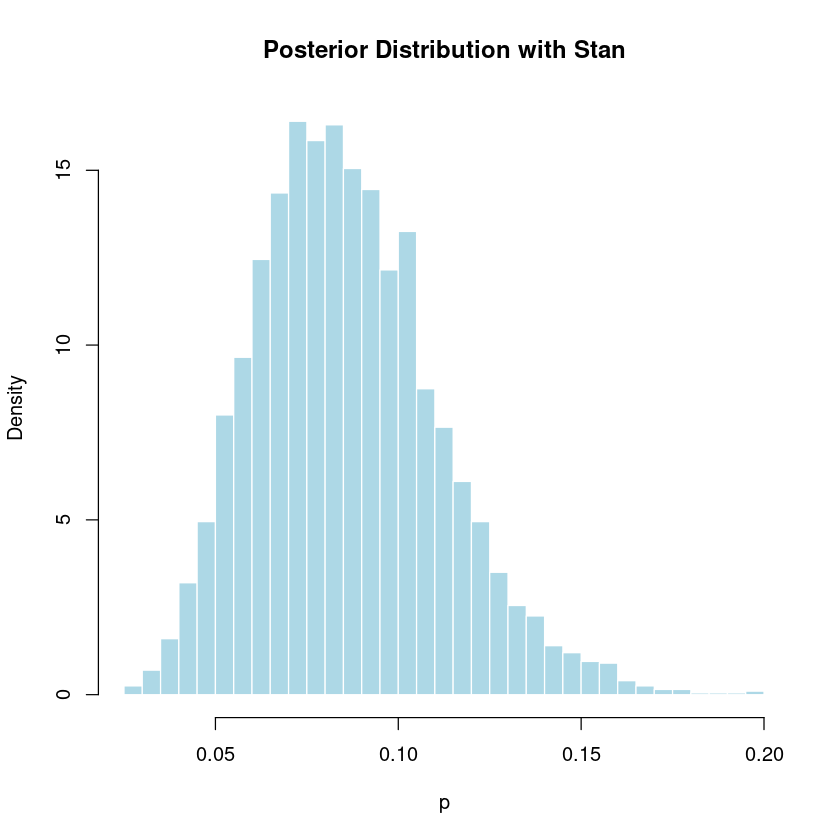

In [10]:
n <- 115
y <- 10

stan_model <- "
data {
    int<lower=0> n;
    int<lower=0> y;
    real<lower=0> a_prior;
    real<lower=0> b_prior;
}
parameters {
    real<lower=0,upper=1> p;
}
model {
    p ~ beta(a_prior, b_prior);
    y ~ binomial(n, p);
}
"

stan_data <- list(
    n = n,
    y = y,
    a_prior = 1,
    b_prior = 11
)

stan_fit <- stan(model_code = stan_model, 
                 data = stan_data, 
                 iter = 2000,
                 chains = 4)

posterior <- extract(stan_fit)$p

p_mean_stan <- mean(posterior)
p_var_stan <- var(posterior)
ci_stan <- quantile(posterior, c(0.025, 0.975))

hist(posterior, breaks = 50, freq = FALSE,
     main = "Posterior Distribution with Stan",
     xlab = "p", col = "lightblue", border = "white")

In [11]:
cat("Posterior mean:", p_mean_stan)
cat("\nPosterior variance:", p_var_stan)
cat("\n95% credible interval: [", ci_stan[1], 
    ",", ci_stan[2], "]")

Posterior mean: 0.08614514
Posterior variance: 0.0006254799
95% credible interval: [ 0.04413924 , 0.1432072 ]